Text (Tweet) Sentiment Classification using GRU <br> By: Lie Reubensto

In [1]:
# Import Libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import f1_score, roc_curve, auc

In [2]:
# Load Dataset
train_path = "./train.csv"
test_path = "./test.csv"

train = pd.read_csv(train_path, header=0, encoding="ISO-8859-1")
test = pd.read_csv(test_path, header=0, encoding="ISO-8859-1")

print(train.shape)
print(test.shape)

(27481, 10)
(4815, 9)


In [3]:
# Check Training Data (first five rows)
train.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [4]:

# Check Training Data Info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


In [5]:
# Check Testing Data (first five rows)
test.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0


In [6]:
# Check Testing Data Info
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4815 entries, 0 to 4814
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            3534 non-null   object 
 1   text              3534 non-null   object 
 2   sentiment         3534 non-null   object 
 3   Time of Tweet     3534 non-null   object 
 4   Age of User       3534 non-null   object 
 5   Country           3534 non-null   object 
 6   Population -2020  3534 non-null   float64
 7   Land Area (Km²)   3534 non-null   float64
 8   Density (P/Km²)   3534 non-null   float64
dtypes: float64(3), object(6)
memory usage: 338.7+ KB


In [7]:
# Only take the relevant columns
train = train[['text', 'sentiment']]
test = test[['text', 'sentiment']]

In [8]:
print(f'Count of unique elements on Train Dataset:\n{train.nunique()}\n')
print(f'Count of unique elements on Test Dataset:\n{test.nunique()}')

Count of unique elements on Train Dataset:
text         27480
sentiment        3
dtype: int64

Count of unique elements on Test Dataset:
text         3534
sentiment       3
dtype: int64


There's three types of sentiment here, which is Positive, Neutral, and Negative

In [9]:
# Check missing value from training data
train.isnull().sum()

text         1
sentiment    0
dtype: int64

In [10]:
# Drop row with missing value from training data
train = train.dropna()

In [11]:
# Check missing value again
train.isnull().sum()

text         0
sentiment    0
dtype: int64

In [12]:
# Check missing value from testing data
test.isnull().sum()

text         1281
sentiment    1281
dtype: int64

In [13]:
# Drop row with missing value from testing data
test = test.dropna()

In [14]:
# Check missing value again
test.isnull().sum()

text         0
sentiment    0
dtype: int64

Drop rows with missing value (because there's still many data remains)

In [15]:
print('Duplicate on Train Dataset: ',train.duplicated().sum())
print('Duplicate on Test Dataset: ',test.duplicated().sum())

Duplicate on Train Dataset:  0
Duplicate on Test Dataset:  0


No more duplicates

In [16]:
train.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [17]:
test.head()

,text,sentiment
0,Last session of the day http://twitpic.com/67ezh,neutral
1,Shanghai is also really exciting (precisely -...,positive
2,"Recession hit Veronique Branquinho, she has to...",negative
3,happy bday!,positive
4,http://twitpic.com/4w75p - I like it!!,positive


In [18]:
# Cleaning text (both training and testing data)
train['text'].apply(lambda x: str.lower(str(x)))
train['text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', str(x)))
test['text'].apply(lambda x: str.lower(str(x)))
test['text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', str(x)))

# Get rid of 'rt' (retweet)
for i, row in train.iterrows():
  train.at[i, 'text'] = re.sub(r'\brt\b', '', str(row['text']))

for i, row in test.iterrows():
  test.at[i, 'text'] = re.sub(r'\brt\b', '', str(row['text']))

# Show how many data each type of sentiment has (for training data)
print(f"Train Positive Sentiments:\n{train[train['sentiment']=='positive'].count()}\n")
print(f"Train Neutral Sentiments:\n{train[train['sentiment']=='neutral'].count()}\n")
print(f"Train Negative Sentiments:\n{train[train['sentiment']=='negative'].count()}")

Train Positive Sentiments:
text         8582
sentiment    8582
dtype: int64

Train Neutral Sentiments:
text         11117
sentiment    11117
dtype: int64

Train Negative Sentiments:
text         7781
sentiment    7781
dtype: int64


In [19]:
train.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [20]:
test.head()

,text,sentiment
0,Last session of the day http://twitpic.com/67ezh,neutral
1,Shanghai is also really exciting (precisely -...,positive
2,"Recession hit Veronique Branquinho, she has to...",negative
3,happy bday!,positive
4,http://twitpic.com/4w75p - I like it!!,positive


In [21]:
# Tokenization
max_features = 2000 # Remember {max_features} most popular unique words only
tokenizer = Tokenizer(num_words=max_features, split=' ')

tokenizer.fit_on_texts(train['text'].values)
train_X = tokenizer.texts_to_sequences(train['text'].values)
train_X = pad_sequences(train_X)

test_X = tokenizer.texts_to_sequences(test['text'].values)
test_X = pad_sequences(test_X, maxlen=train_X.shape[1])

In [22]:
# Label Encoding (from string to integers)
le = LabelEncoder()
train_Y = le.fit_transform(train['sentiment'])
test_Y = le.transform(test['sentiment'])

In [23]:
# Display the mapping of original labels to encoded labels
for original, encoded in zip(le.classes_, range(len(le.classes_))):
    print(f"{original} -> {encoded}")

negative -> 0
neutral -> 1
positive -> 2


In [24]:
# Split Training Data to Training and Validation Data
train_X, val_X, train_Y, val_Y = tts(train_X, train_Y, train_size=0.8, random_state=42)

print(train_X.shape)
print(val_X.shape)
print(test_X.shape)

print(train_Y.shape)
print(val_Y.shape)
print(test_Y.shape)

(21984, 34)
(5496, 34)
(3534, 34)
(21984,)
(5496,)
(3534,)


In [25]:
# Model for predictions (using GRU)
model = models.Sequential()
model.add(layers.Embedding(input_dim=max_features, output_dim=128, input_length=train_X.shape[1]))
model.add(layers.GRU(128, dropout=0.5, return_sequences=True))
model.add(layers.SpatialDropout1D(0.5))
model.add(layers.GRU(128, dropout=0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 128)           256000    
                                                                 
 gru (GRU)                   (None, 34, 128)           99072     
                                                                 
 spatial_dropout1d (Spatial  (None, 34, 128)           0         
 Dropout1D)                                                      
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

In [26]:
# Train Model
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2, min_lr=1e-6, verbose=2)
history = model.fit(train_X, train_Y, validation_data=(val_X, val_Y), epochs=15, batch_size=16, verbose=2, callbacks=[lr_scheduler])

Epoch 1/15
1374/1374 - 47s - loss: 0.8504 - accuracy: 0.6077 - val_loss: 0.6913 - val_accuracy: 0.7069 - lr: 0.0010 - 47s/epoch - 34ms/step
Epoch 2/15
1374/1374 - 51s - loss: 0.6858 - accuracy: 0.7257 - val_loss: 0.6703 - val_accuracy: 0.7152 - lr: 0.0010 - 51s/epoch - 37ms/step
Epoch 3/15
1374/1374 - 51s - loss: 0.6461 - accuracy: 0.7401 - val_loss: 0.6665 - val_accuracy: 0.7283 - lr: 0.0010 - 51s/epoch - 37ms/step
Epoch 4/15
1374/1374 - 52s - loss: 0.6252 - accuracy: 0.7483 - val_loss: 0.6747 - val_accuracy: 0.7262 - lr: 0.0010 - 52s/epoch - 38ms/step
Epoch 5/15

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1374/1374 - 36s - loss: 0.6035 - accuracy: 0.7609 - val_loss: 0.6770 - val_accuracy: 0.7200 - lr: 0.0010 - 36s/epoch - 26ms/step
Epoch 6/15
1374/1374 - 31s - loss: 0.5582 - accuracy: 0.7834 - val_loss: 0.6883 - val_accuracy: 0.7254 - lr: 1.0000e-04 - 31s/epoch - 22ms/step
Epoch 7/15

Epoch 7: ReduceLROnPlateau reducing learning rate to 1.00000004749

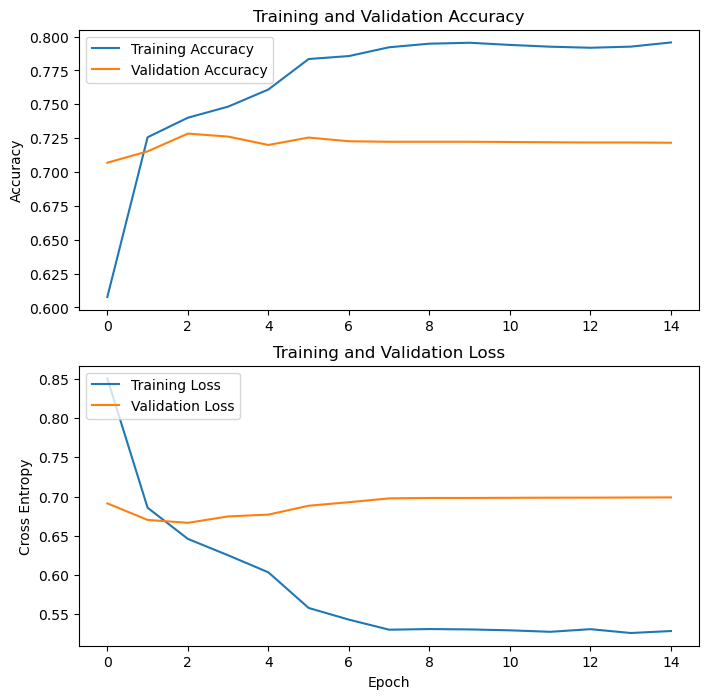

In [27]:
# Training-Validation result of model
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.title('Training and Validation Accuracy')
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(2, 1, 2)
plt.title('Training and Validation Loss')
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.legend(loc='upper left')

plt.show()

Model is heavily overfit

In [28]:
# Evaluate Model using Testing Data
model.evaluate(test_X, test_Y)

111/111 [==============================] - 2s 18ms/step - loss: 0.6868 - accuracy: 0.7326


[0.686791181564331, 0.7325976490974426]

In [29]:
# See the predictions
y_pred = model.predict(test_X)
y_pred_class = np.argmax(y_pred, axis=1)

real_labels = le.inverse_transform(test_Y)
predicted_labels = le.inverse_transform(y_pred_class)

results_df = pd.DataFrame({
    'Text': test['text'],
    'Real Label': real_labels,
    'Predicted Label': predicted_labels 
})

pd.set_option('display.max_colwidth', None)
results_df

111/111 [==============================] - 3s 17ms/step


,Text,Real Label,Predicted Label
0,Last session of the day http://twitpic.com/67ezh,neutral,neutral
1,Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China: (SH) (BJ).,positive,positive
2,"Recession hit Veronique Branquinho, she has to quit her company, such a shame!",negative,negative
3,happy bday!,positive,positive
4,http://twitpic.com/4w75p - I like it!!,positive,positive
...,...,...,...
3529,"its at 3 am, im very tired but i can`t sleep but i try it",negative,negative
3530,"All alone in this old house again. Thanks for the net which keeps me alive and kicking! Whoever invented the net, i wanna kiss your hair!",positive,neutral
3531,I know what you mean. My little dog is sinking into depression... he wants to move someplace tropical,negative,neutral
3532,_sutra what is your next youtube video gonna be about? I love your videos!,positive,positive


In [30]:
# Calculate the F1-Score of the model
f1 = f1_score(test_Y, y_pred_class, average='weighted')
print(f"F1 Score: {f1:.3f}")

F1 Score: 0.734


In [31]:
# Get AUC value
y_test_binarized = label_binarize(test_Y, classes=[0, 1, 2])
fpr0, tpr0, _ = roc_curve(y_test_binarized[:, 0], y_pred[:, 0])
fpr1, tpr1, _ = roc_curve(y_test_binarized[:, 1], y_pred[:, 1])
fpr2, tpr2, _ = roc_curve(y_test_binarized[:, 2], y_pred[:, 2])

roc_auc_graph0 = auc(fpr0, tpr0)
roc_auc_graph1 = auc(fpr1, tpr1)
roc_auc_graph2 = auc(fpr2, tpr2)

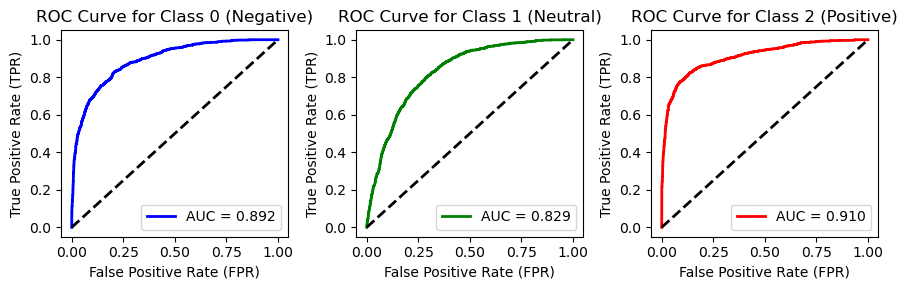

In [32]:
# Plot ROC Curve
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

# Plot for class 0
axes[0].plot(fpr0, tpr0, color='blue', lw=2, label=f'AUC = {roc_auc_graph0:.3f}')
axes[0].plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
axes[0].set_xlabel('False Positive Rate (FPR)')
axes[0].set_ylabel('True Positive Rate (TPR)')
axes[0].set_title('ROC Curve for Class 0 (Negative)')
axes[0].legend(loc='lower right')

# Plot for class 1
axes[1].plot(fpr1, tpr1, color='green', lw=2, label=f'AUC = {roc_auc_graph1:.3f}')
axes[1].plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
axes[1].set_xlabel('False Positive Rate (FPR)')
axes[1].set_ylabel('True Positive Rate (TPR)')
axes[1].set_title('ROC Curve for Class 1 (Neutral)')
axes[1].legend(loc='lower right')

# Plot for class 2
axes[2].plot(fpr2, tpr2, color='red', lw=2, label=f'AUC = {roc_auc_graph2:.3f}')
axes[2].plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
axes[2].set_xlabel('False Positive Rate (FPR)')
axes[2].set_ylabel('True Positive Rate (TPR)')
axes[2].set_title('ROC Curve for Class 2 (Positive)')
axes[2].legend(loc='lower right')

plt.tight_layout()
plt.show()

In [33]:
# Clear Session
tf.keras.backend.clear_session()